<h1 style="text-align: center;color:blue"><em>Daniel Juravski 206082323</em></h1>

# Question 01:

1. Let $N$ be the number of the people at the begining of the experience and $N_t$ be the number of the people that experienced an event until time $t$.

$S_1(t) = \frac{N-N_t}{N}
        = \frac{N}{N}-\frac{N_t}{N}
        = 1 - \frac{N_t}{N}$
         
2. Let $t_i$ be the time when at least one event happened, $d_i$ the number of events (e.g., deaths) that happened at time $t_i$, and $n_i$ the individuals known to have survived (have not yet had an event or been censored) up to time $t_i$.

$S_2(t) = \displaystyle \prod_{i: t_i \leq t} (1-\frac{d_i}{n_i})$

Suppose there is no censore, all the events happens in a single time $t$, i.e 

$S_2(t) = 1-\frac{d_t}{n_t} = S_1(t)$ $\blacksquare$


# Question 02:

Question 02 solution ...

#  Retinopathy Part:

In [1]:
import lifelines as ll
from lifelines.statistics import logrank_test
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
RETINOPATHY_DATA = '/home/daniel/Documents/MachineLearning4HealthCare/ml4hc/data/diabetic_retinopathy/data.xlsx'
rt = pd.read_excel(RETINOPATHY_DATA)

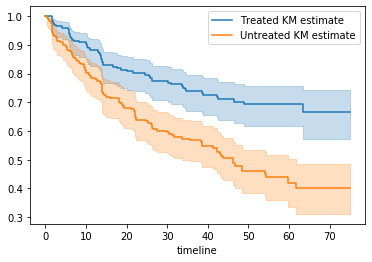

In [3]:
tr_km = ll.KaplanMeierFitter()
tr_km_plt = tr_km.fit(rt["tr_time"], rt["tr_status"], label="Treated KM estimate").plot()

untr_km = ll.KaplanMeierFitter()
untr_km_plt = untr_km.fit(rt["untr_time"], rt["untr_status"], label="Untreated KM estimate").plot()

log_rank_test = ll.statistics.logrank_test(rt["tr_time"], rt["untr_time"],
                                           rt["tr_status"], rt["untr_status"])
log_rank_test.print_summary()

We can see that the survivng curve of the treated samples is significantly ($p<0.005$) above the survivng curve of the untreated samples.

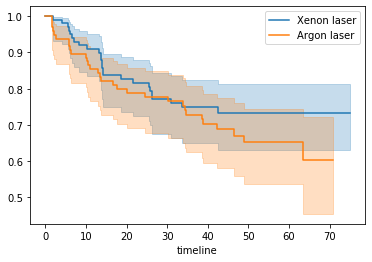

In [4]:
lt1_samples = rt.query("laser_type==1")
lt2_samples = rt.query("laser_type==2")

lt1_km = ll.KaplanMeierFitter()
lt1_km_plt = lt1_km.fit(lt1_samples["tr_time"], lt1_samples["tr_status"], label="Xenon laser").plot()

lt2_km = ll.KaplanMeierFitter()
lt2_km_plt = lt2_km.fit(lt2_samples["tr_time"], lt2_samples["tr_status"], label="Argon laser").plot()

log_rank_test = ll.statistics.logrank_test(lt1_samples["tr_time"], lt2_samples["tr_time"],
                                           lt1_samples["tr_status"], lt2_samples["tr_status"])
log_rank_test.print_summary()

While visualy the survivng curve of the Xenon laser is a bit above the survivng curve of the Argon samples, it isn't significantly separated ($p=0.28$) by the logrank test.

#  GBM Part:

In [5]:
GBM_DATA = '/home/daniel/Documents/MachineLearning4HealthCare/ml4hc/data/glioblastomamutations/data.csv'

G_START = 6
G_END = 505
G_NUM = G_END - G_START + 1

gbm = pd.read_csv(GBM_DATA)

# encode Life and Race attributs
def encode_life_race(gbm):
    le_life = LabelEncoder()
    gbm['e_Life'] = le_life.fit_transform(gbm['Life']) + 1
    ohe = OneHotEncoder()
    race = ohe.fit_transform(gbm['Race'].values.reshape(-1, 1)).toarray()
    dfOneHot = pd.DataFrame(race, columns=["Race_" + str(int(i)) for i in range(race.shape[1])])
    gbm = pd.concat([gbm, dfOneHot], axis=1)

    return gbm

gbm = encode_life_race(gbm)

In [6]:
def find_significant_genes(gbm, G_START, G_END):
    gene2pval = {}
    for g in gbm.columns[G_START:G_END + 1]:
        g_is_0_samples = gbm.query("{0}==0".format(g))
        g_is_1_samples = gbm.query("{0}==1".format(g))
        log_rank_test = ll.statistics.logrank_test(g_is_0_samples["Days Till Death"], g_is_1_samples["Days Till Death"],
                                                   g_is_0_samples['e_Life'], g_is_1_samples['e_Life'])
        gene2pval[g] = log_rank_test.p_value

    # sort by p-vals
    gene2pval = {k: v for k, v in sorted(gene2pval.items(), key=lambda item: item[1])}

    num_significant_g = 0
    for g, p in gene2pval.items():
        if p < 0.05:
            num_significant_g += 1
            print("Significant gene: {0} p-val: {1}".format(g, p))
    print("Number significant genes: {0}".format(num_significant_g))

    return gene2pval

In [7]:
def find_fdr_group(gene2pval, G_NUM):
    print("Genes in FDR group:")
    for i, (g, p) in enumerate(gene2pval.items()):
        fdr = 0.05 * (i + 1) / G_NUM
        if p < fdr:
            print("Significant gene: {0} p-val: {1} fdr-val: {2}".format(g, p, fdr))

In [8]:
gene2pval = find_significant_genes(gbm, G_START, G_END)

Significant gene: NLRP4 p-val: 2.5009785740925407e-06
Significant gene: ITGAD p-val: 0.0031546538233991187
Significant gene: IDH1 p-val: 0.0037927091264097755
Significant gene: CALN1 p-val: 0.0045010229640885845
Significant gene: MAGI1 p-val: 0.0049114486873439635
Significant gene: ITGB4 p-val: 0.005478764989712263
Significant gene: ADAMTS12 p-val: 0.008349910984487292
Significant gene: DNAH17 p-val: 0.011187403342969006
Significant gene: PRUNE2 p-val: 0.011478759143161169
Significant gene: TP53 p-val: 0.013232213454231558
Significant gene: PCDHB5 p-val: 0.0179432224815737
Significant gene: MYCBP2 p-val: 0.02305598832519469
Significant gene: MUC16 p-val: 0.02774108152888992
Significant gene: AKAP13 p-val: 0.028259081149520106
Significant gene: ABCB4 p-val: 0.029415347498216903
Significant gene: PDZD2 p-val: 0.03905444633877325
Significant gene: AFF2 p-val: 0.04174531465780325
Significant gene: MADD p-val: 0.04644599833601811
Significant gene: TLN2 p-val: 0.04676895749958001
Significant

There are 21 genes that significantly separates the GBM events.

In [9]:
find_fdr_group(gene2pval, G_NUM)

Genes in FDR group:
Significant gene: NLRP4 p-val: 2.5009785740925407e-06 fdr-val: 0.0001


The FDR group is composed out of a single gene: NLRP4

In [10]:
models_info_list = []
def train_cox_model(data, features):
    gbm_mini = data[features]
    gbm_cox = ll.CoxPHFitter()
    gbm_cox.fit(gbm_mini, duration_col='Days Till Death', event_col='e_Life')
    gbm_cox.print_summary()

    return gbm_cox.log_likelihood_, gbm_cox.concordance_index_

In [11]:
log_liklihood, concordance = train_cox_model(gbm, ["Days Till Death", "e_Life", "Race_0", "Race_1", "Race_2", "NLRP4", "ITGAD", "IDH1", "CALN1", "MAGI1", "ITGB4"])
models_info_list.append({"model features": "Race, NLRP4, ITGAD, IDH1, CALN1, MAGI1, ITGB4",
                         "log likelihood": log_liklihood,
                         "concordance": concordance})

In [12]:
log_liklihood, concordance = train_cox_model(gbm, ["Days Till Death", "e_Life", "NLRP4", "ITGAD", "IDH1", "CALN1", "MAGI1", "ITGB4"])
models_info_list.append({"model features": "NLRP4, ITGAD, IDH1, CALN1, MAGI1, ITGB4",
                         "log likelihood": log_liklihood,
                         "concordance": concordance})

In [13]:
log_liklihood, concordance = train_cox_model(gbm, ["Days Till Death", "e_Life", "NLRP4"])
models_info_list.append({"model features": "NLRP4",
                         "log likelihood": log_liklihood,
                         "concordance": concordance})

In [14]:
log_liklihood, concordance = train_cox_model(gbm, ["Days Till Death", "e_Life", "ITGAD"])
models_info_list.append({"model features": "ITGAD",
                         "log likelihood": log_liklihood,
                         "concordance": concordance})

In [15]:
log_liklihood, concordance = train_cox_model(gbm, ["Days Till Death", "e_Life", "IDH1"])
models_info_list.append({"model features": "IDH1",
                         "log likelihood": log_liklihood,
                         "concordance": concordance})

In [16]:
log_liklihood, concordance = train_cox_model(gbm, ["Days Till Death", "e_Life", "CALN1"])
models_info_list.append({"model features": "CALN1",
                         "log likelihood": log_liklihood,
                         "concordance": concordance})

In [17]:
log_liklihood, concordance = train_cox_model(gbm, ["Days Till Death", "e_Life", "MAGI1"])
models_info_list.append({"model features": "MAGI1",
                         "log likelihood": log_liklihood,
                         "concordance": concordance})

In [18]:
log_liklihood, concordance = train_cox_model(gbm, ["Days Till Death", "e_Life", "ITGB4"])
models_info_list.append({"model features": "ITGB4",
                         "log likelihood": log_liklihood,
                         "concordance": concordance})

In [19]:
models_info = pd.DataFrame(models_info_list)
print(models_info)

                                  model features  log likelihood  concordance
0  Race, NLRP4, ITGAD, IDH1, CALN1, MAGI1, ITGB4    -1387.651626     0.589636
1        NLRP4, ITGAD, IDH1, CALN1, MAGI1, ITGB4    -1388.193803     0.574702
2                                          NLRP4    -1407.999969     0.525347
3                                          ITGAD    -1411.788300     0.514655
4                                           IDH1    -1409.747707     0.519454
5                                          CALN1    -1411.854337     0.512121
6                                          MAGI1    -1410.031795     0.513952
7                                          ITGB4    -1412.089060     0.514320


From the above table, we can extract several insights:
1. The model that did the best was model 0 - the one that used all the 6 genes and the "Race" features.
2. Model 0 achieved a better performance than models 2,3,4,5,6 and 7 - that used a single gene as a feature.
3. Model 1 also achieved a better model than the single gene models, so we might wonder if the success of model 0 stems from the "Race" feature or the combination of all the 6 genes.